In [1]:
import pandas, seaborn, umap, numpy, collections

import sklearn, sklearn.preprocessing, sklearn.decomposition, sklearn.manifold
import scipy, scipy.stats
import statsmodels, statsmodels.stats, statsmodels.stats.multitest

import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':20, 'ytick.labelsize':20, 'figure.figsize':(9, 6), 'axes.labelsize':20})

# User-defined variables

In [2]:
storage_file = '/home/adrian/gd15/hi/research/huvec/results/untargeted/cell_number_sample_and_batch_normalized_log10_intensities_untargeted_data.csv'
annotation_file = '/home/adrian/gd15/hi/research/huvec/results/untargeted/Annotations of Adrians hits.xlsx'

In [3]:
treatments = ['EGM', '1.0', '10.0', '100.0']
timepoints = [0, 4, 24]

conditions = [('EGM', 0), ('EGM', 4), ('EGM', 24)]
for timepoint in timepoints[1:]:
  for treatment in treatments[1:]:
    condition = (treatment, timepoint)
    conditions.append(condition)
print(conditions, len(conditions))

condition_colors = ['white', 'white', 'white', 'green', 'yellow', 'red', 'green', 'yellow', 'red']
condition_labels = ['c 0h', 'c 4h', 'c 24h', '0.5 4h', '5 4h', '50 4h', '0.5 24h', '5 24h', '50 24h']

print(condition_colors, len(condition_colors))

[('EGM', 0), ('EGM', 4), ('EGM', 24), ('1.0', 4), ('10.0', 4), ('100.0', 4), ('1.0', 24), ('10.0', 24), ('100.0', 24)] 9
['white', 'white', 'white', 'green', 'yellow', 'red', 'green', 'yellow', 'red'] 9


# Read information

## read metadata

In [4]:
# read ottars annotation file
annotation = pandas.read_excel(annotation_file, usecols=['ottar calls', 'dose-responding mz', 'annotated mz'])
annotation.head()

,ottar calls,dose-responding mz,annotated mz
0,glutamate,146.0799,146.043687
1,N-acetyl-glutamate,102.0536,102.053623
2,N-acetyl-glutamate,144.0646,144.064567
3,pantothenic acid,218.1016,218.101624
4,cholesterol derivative,321.1625,321.209535


In [5]:
annotation['diff'] = numpy.abs(annotation['dose-responding mz'] - annotation['annotated mz'])
print(annotation.shape)
annotation = annotation[annotation['diff'] < 0.01]
print(annotation.shape)
#annotation.tail(50)

(118, 4)
(64, 4)


## read data

In [6]:
wdf = pandas.read_csv(storage_file, index_col=0)
print(wdf.shape)
wdf.head()

(123, 1233)


,Treatment,Time,Replicate,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EGM,0.0,0.0,2.731190,3.039996,2.498900,3.146793,2.926058,3.101473,4.249783,...,3.021206,2.995128,3.012682,3.068779,3.026200,3.681500,3.728084,3.902864,3.798414,3.779298
1,EGM,0.0,1.0,2.577060,2.966918,2.478636,3.080018,2.975931,3.142122,4.154512,...,3.197100,3.191962,3.090010,3.086108,2.856756,3.666367,3.817882,3.767177,3.784470,3.692333
2,EGM,0.0,2.0,2.567796,3.102377,2.315301,3.174088,3.080577,3.078214,3.950247,...,3.201853,3.251763,3.087607,3.325044,2.495992,3.780564,3.908326,3.861871,3.913619,3.892816
3,EGM,0.0,3.0,2.700993,3.041685,2.328574,3.091159,2.993070,3.046918,4.165901,...,3.056800,3.136908,3.002354,3.164014,2.818191,3.743018,3.851108,3.838991,3.750062,3.818045
4,EGM,0.0,4.0,2.769198,2.967684,2.802023,3.049199,3.131748,3.324679,4.004245,...,3.029694,2.993319,2.978906,3.192828,2.418012,3.710214,3.601818,3.757961,3.739917,3.710246


In [7]:
wdf.columns[wdf.isna().any()].tolist()

[]

In [8]:
peak_names = wdf.columns.to_list()[3:]
print(peak_names)
print(len(peak_names))

['X59.01097', 'X61.017890000000001', 'X67.016220000000004', 'X74.021450000000002', 'X77.052040000000005', 'X77.052049999999994', 'X78.956580000000002', 'X78.956770000000006', 'X79.955420000000004', 'X80.962869999999995', 'X80.962720000000004', 'X82.951819999999998', 'X84.006739999999994', 'X84.043059999999997', 'X84.949100000000001', 'X85.027289999999994', 'X85.027019999999993', 'X85.027270000000001', 'X86.991519999999994', 'X87.006460000000004', 'X88.037970000000001', 'X88.037940000000006', 'X88.038039999999995', 'X88.03792', 'X89.022130000000004', 'X89.022099999999995', 'X89.040549999999996', 'X92.032160000000005', 'X92.031949999999995', 'X92.925600000000003', 'X93.043189999999996', 'X94.922759999999997', 'X96.919939999999997', 'X96.965789999999998', 'X96.967179999999999', 'X96.957989999999995', 'X96.965829999999997', 'X97.009529999999998', 'X100.0742', 'X102.02508', 'X102.05382', 'X102.05362', 'X102.94647999999999', 'X102.94672', 'X102.95457', 'X104.03297000000001', 'X104.95166', 'X

# Spot check for adrenaline metabolite sulfate


In [9]:
wdf.tail()

,Treatment,Time,Replicate,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
118,100.0,24.0,7.0,2.779846,3.172528,2.963769,3.251544,2.761526,3.189147,3.857269,...,2.588433,2.790295,2.704459,3.055224,2.654439,3.312947,3.594402,3.602590,3.522195,3.542725
119,100.0,24.0,8.0,2.724025,3.133532,2.647625,3.245464,3.240781,3.462044,4.146592,...,2.828934,2.951793,3.020111,3.267789,2.152626,3.748962,3.874495,3.837302,3.871287,3.820243
120,100.0,24.0,9.0,2.682043,3.035865,2.960725,3.047795,2.949646,3.273423,4.064389,...,2.884726,2.955181,2.822045,3.137322,2.050516,3.608898,3.770203,3.810570,3.823127,3.706630
121,100.0,24.0,10.0,2.788015,3.051387,2.434155,3.047309,2.829969,3.312372,4.180174,...,2.600986,2.790380,2.908164,3.105119,2.813513,3.552164,3.741591,3.809609,3.746415,3.739735
122,100.0,24.0,11.0,2.615944,2.868514,2.503521,2.948165,3.041068,3.020996,4.136712,...,2.950874,3.006080,2.912122,3.051190,2.604046,3.630214,3.659103,3.695250,3.842232,3.624031


In [10]:
target = 'epinephrine sulfate'
peak_mz = float(annotation[annotation['ottar calls'] == target]['dose-responding mz'])
peak_mz


262.0386

In [11]:
match = None
for column in wdf.columns[3:]:
  value = float(column[1:13])
  diff = numpy.abs(peak_mz - value)
  if diff < 1e-4:
    print(diff)
    match = column
print(match)

working_peak_mz = match

9.999951089412207e-09
X262.03859999999997


In [12]:
plotting_values = []

for condition in conditions:
  treatment = condition[0]; timepoint = condition[1]

  sub = wdf[(wdf['Treatment'] == treatment) & (wdf['Time'] == timepoint)][working_peak_mz]
  box = sub.values
  plotting_values.append(box)

  print('treatment {}, timepoint {}, shape {}'.format(treatment, timepoint, sub.shape))

treatment EGM, timepoint 0, shape (6,)
treatment EGM, timepoint 4, shape (15,)
treatment EGM, timepoint 24, shape (15,)
treatment 1.0, timepoint 4, shape (15,)
treatment 10.0, timepoint 4, shape (15,)
treatment 100.0, timepoint 4, shape (15,)
treatment 1.0, timepoint 24, shape (15,)
treatment 10.0, timepoint 24, shape (15,)
treatment 100.0, timepoint 24, shape (12,)


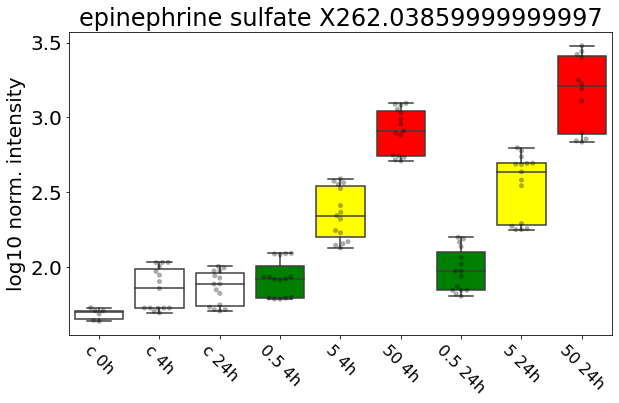

<Figure size 648x432 with 0 Axes>

In [13]:
matplotlib.pyplot.figure(figsize=(9, 6))

g = seaborn.boxplot(data=plotting_values)
h = seaborn.swarmplot(data=plotting_values, color='black', alpha=1/3)

g.set(ylabel='log10 norm. intensity', title='{} {}'.format(target, working_peak_mz))
for i in range(len(g.artists)):
    g.artists[i].set_facecolor(condition_colors[i])
matplotlib.pyplot.xticks(list(range(len(condition_colors))), condition_labels, fontsize=16, rotation=-45)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()
matplotlib.pyplot.clf()

# Visualization of all samples

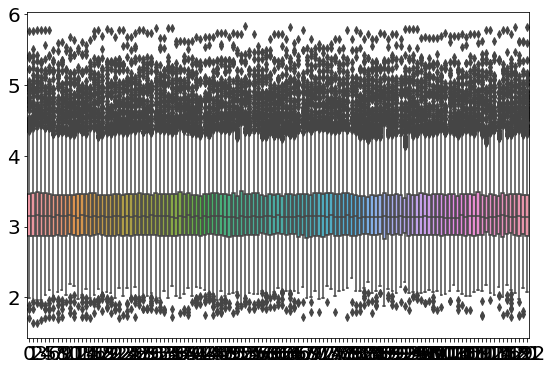

(1230, 123)


In [14]:
tdf = wdf.transpose()
tdf.head()

tdf.drop(['Treatment', 'Time', 'Replicate'], axis=0, inplace=True)
tdf.head()

matplotlib.pyplot.figure(figsize=(9, 6))
seaborn.boxplot(data=tdf)
matplotlib.pyplot.show()
print(tdf.shape)

In [15]:
wdf.head()

,Treatment,Time,Replicate,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EGM,0.0,0.0,2.731190,3.039996,2.498900,3.146793,2.926058,3.101473,4.249783,...,3.021206,2.995128,3.012682,3.068779,3.026200,3.681500,3.728084,3.902864,3.798414,3.779298
1,EGM,0.0,1.0,2.577060,2.966918,2.478636,3.080018,2.975931,3.142122,4.154512,...,3.197100,3.191962,3.090010,3.086108,2.856756,3.666367,3.817882,3.767177,3.784470,3.692333
2,EGM,0.0,2.0,2.567796,3.102377,2.315301,3.174088,3.080577,3.078214,3.950247,...,3.201853,3.251763,3.087607,3.325044,2.495992,3.780564,3.908326,3.861871,3.913619,3.892816
3,EGM,0.0,3.0,2.700993,3.041685,2.328574,3.091159,2.993070,3.046918,4.165901,...,3.056800,3.136908,3.002354,3.164014,2.818191,3.743018,3.851108,3.838991,3.750062,3.818045
4,EGM,0.0,4.0,2.769198,2.967684,2.802023,3.049199,3.131748,3.324679,4.004245,...,3.029694,2.993319,2.978906,3.192828,2.418012,3.710214,3.601818,3.757961,3.739917,3.710246


In [16]:
# Separating out the features
x = wdf.loc[:, peak_names].values

sub4 = wdf[wdf['Time'] == 4]
x4 = sub4.loc[:, peak_names].values

sub24 = wdf[wdf['Time'] == 24]
x24 = sub24.loc[:, peak_names].values

print(x[:3])

[[2.73119002 3.03999643 2.49889979 ... 3.90286354 3.79841371 3.77929788]
 [2.57705968 2.96691755 2.47863587 ... 3.76717719 3.78446988 3.69233337]
 [2.56779611 3.10237684 2.31530088 ... 3.86187114 3.91361893 3.89281611]]


In [17]:
# Standardizing the features
x = sklearn.preprocessing.StandardScaler().fit_transform(x)
x4 = sklearn.preprocessing.StandardScaler().fit_transform(x4)
x24 = sklearn.preprocessing.StandardScaler().fit_transform(x24)
x[:3]

array([[ 0.47671593,  0.3518314 , -0.61884887, ...,  1.46534957,
         0.50069521,  0.54273793],
       [-1.17237781, -0.45311811, -0.72210196, ...,  0.00453192,
         0.35610128, -0.32833978],
       [-1.27149199,  1.03893931, -1.5543615 , ...,  1.02401982,
         1.69534362,  1.67979031]])

## PCA for all samples

In [18]:
pca = sklearn.decomposition.PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principal_df = pandas.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

print(principal_df.shape)
principal_df.head()

(123, 2)


,PC1,PC2
0,3.693295,6.490856
1,-2.834521,-2.564059
2,-4.128783,-15.184278
3,-2.565232,-4.151199
4,11.313781,-5.972875


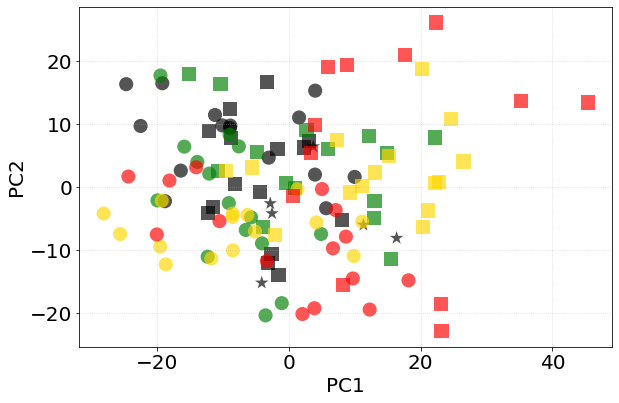

In [19]:
matplotlib.pyplot.figure(figsize=(9, 6))

for i in range(len(wdf.index)):

  # colors
  if wdf.iloc[i]['Treatment'] == 'EGM':
    plotting_color = 'black'
  elif wdf.iloc[i]['Treatment'] == '1.0':
    plotting_color = 'green'
  elif wdf.iloc[i]['Treatment'] == '10.0':
    plotting_color = 'gold'
  elif wdf.iloc[i]['Treatment'] == '100.0':
    plotting_color = 'red'
  else:
    print('error')

  # markers
  if wdf.iloc[i]['Time'] == 0:
    plotting_marker = '*'
  elif wdf.iloc[i]['Time'] == 4:
    plotting_marker = 'o'
  elif wdf.iloc[i]['Time'] == 24:
    plotting_marker = 's'
  else:
    print('error')

  # position
  posx = principal_df.iloc[i]['PC1']
  posy = principal_df.iloc[i]['PC2']

  # plot
  matplotlib.pyplot.scatter(posx, posy, s=200, c=plotting_color, alpha=2/3, ec=None, marker=plotting_marker)

matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('PC1')
matplotlib.pyplot.ylabel('PC2')
matplotlib.pyplot.tight_layout()

#matplotlib.show()
#matplotlib.pyplot.savefig('/content/drive/MyDrive/hi/research/huvec/results/untargeted/figures/pca_all.svg')
#matplotlib.pyplot.clf()

## tSNSE of all samples

In [20]:
embedding = sklearn.manifold.TSNE(n_components=2, init='pca', verbose=1, perplexity=15, learning_rate=10, metric='cosine', early_exaggeration=3, method='exact').fit_transform(x)

/home/adrian/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 123 / 123
[t-SNE] Mean sigma: 0.260131
[t-SNE] KL divergence after 250 iterations with early exaggeration: 7.654388
[t-SNE] KL divergence after 1000 iterations: 0.521122


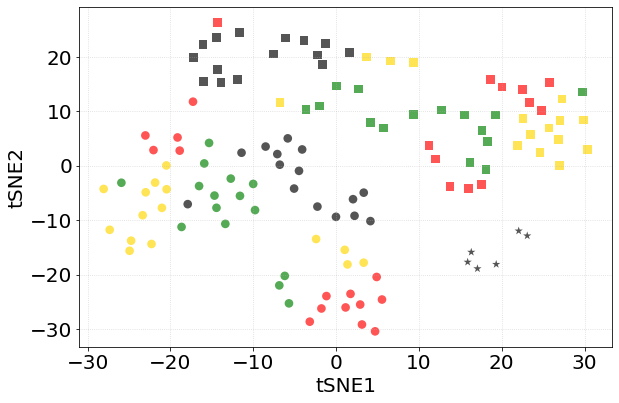

In [21]:
matplotlib.pyplot.figure(figsize=(9, 6))

for i in range(len(wdf.index)):

  # colors
  if wdf.iloc[i]['Treatment'] == 'EGM':
    plotting_color = 'black'
  elif wdf.iloc[i]['Treatment'] == '1.0':
    plotting_color = 'green'
  elif wdf.iloc[i]['Treatment'] == '10.0':
    plotting_color = 'gold'
  elif wdf.iloc[i]['Treatment'] == '100.0':
    plotting_color = 'red'
  else:
    print('error')

  # markers
  if wdf.iloc[i]['Time'] == 0:
    plotting_marker = '*'
  elif wdf.iloc[i]['Time'] == 4:
    plotting_marker = 'o'
  elif wdf.iloc[i]['Time'] == 24:
    plotting_marker = 's'
  else:
    print('error')

  # position
  posx = embedding[i][0]
  posy = embedding[i][1]

  # plot
  matplotlib.pyplot.scatter(posx, posy, s=75, c=plotting_color, alpha=2/3, ec=None, marker=plotting_marker)

matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('tSNE1')
matplotlib.pyplot.ylabel('tSNE2')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

## UMAP of all samples

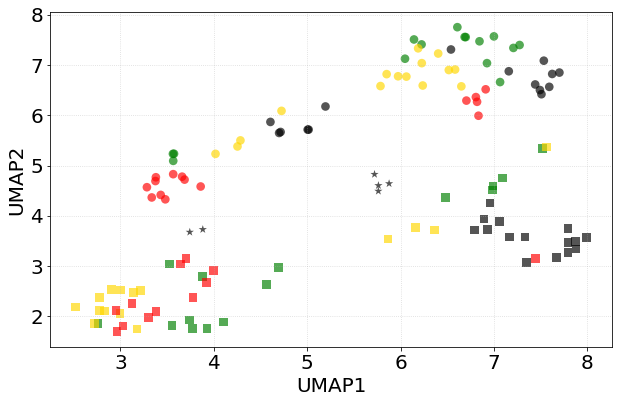

In [22]:
reducer = umap.UMAP(metric='cosine', n_neighbors=15, min_dist=0)
umap_embedding = reducer.fit_transform(x)

matplotlib.pyplot.figure(figsize=(9, 6))

for i in range(len(wdf.index)):

  # colors
  if wdf.iloc[i]['Treatment'] == 'EGM':
    plotting_color = 'black'
  elif wdf.iloc[i]['Treatment'] == '1.0':
    plotting_color = 'green'
  elif wdf.iloc[i]['Treatment'] == '10.0':
    plotting_color = 'gold'
  elif wdf.iloc[i]['Treatment'] == '100.0':
    plotting_color = 'red'
  else:
    print('error')

  # markers
  if wdf.iloc[i]['Time'] == 0:
    plotting_marker = '*'
  elif wdf.iloc[i]['Time'] == 4:
    plotting_marker = 'o'
  elif wdf.iloc[i]['Time'] == 24:
    plotting_marker = 's'
  else:
    print('error')

  # position
  posx = umap_embedding[i][0]
  posy = umap_embedding[i][1]

  # plot
  matplotlib.pyplot.scatter(posx, posy, s=75, c=plotting_color, alpha=2/3, ec=None, marker=plotting_marker)

matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('UMAP1')
matplotlib.pyplot.ylabel('UMAP2')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()
# really need to do it at separate times two figures. go for it

# Visualization for 4 h samples

## PCA for 4 h samples

In [23]:
pca = sklearn.decomposition.PCA(n_components=2)
principalComponents = pca.fit_transform(x4)
principal_df = pandas.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

print(principal_df.shape)
principal_df.head()

(60, 2)


,PC1,PC2
0,-8.717023,17.628754
1,-10.111783,14.720841
2,8.862417,13.943202
3,-11.353586,9.871167
4,-9.736214,11.123833


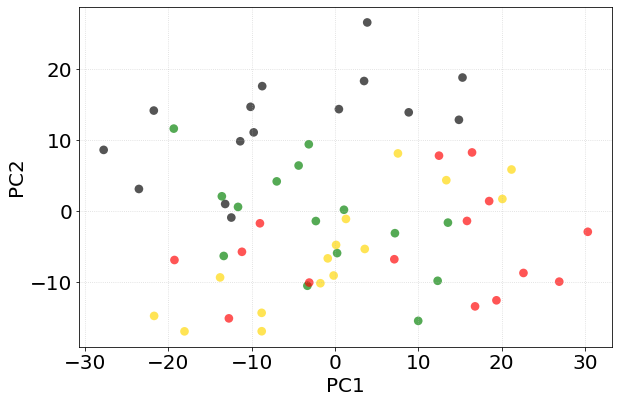

In [24]:
matplotlib.pyplot.figure(figsize=(9, 6))

for i in range(len(sub4.index)):

  # colors
  if sub4.iloc[i]['Treatment'] == 'EGM':
    plotting_color = 'black'
  elif sub4.iloc[i]['Treatment'] == '1.0':
    plotting_color = 'green'
  elif sub4.iloc[i]['Treatment'] == '10.0':
    plotting_color = 'gold'
  elif sub4.iloc[i]['Treatment'] == '100.0':
    plotting_color = 'red'
  else:
    print('error')

  # markers
  if sub4.iloc[i]['Time'] == 0:
    plotting_marker = '*'
  elif sub4.iloc[i]['Time'] == 4:
    plotting_marker = 'o'
  elif sub4.iloc[i]['Time'] == 24:
    plotting_marker = 's'
  else:
    print('error')

  # position
  posx = principal_df.iloc[i]['PC1']
  posy = principal_df.iloc[i]['PC2']

  # plot
  matplotlib.pyplot.scatter(posx, posy, s=75, c=plotting_color, alpha=2/3, ec=None, marker=plotting_marker)

matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('PC1')
matplotlib.pyplot.ylabel('PC2')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

## tSNE for 4 h samples

/home/adrian/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 60 samples in 0.000s...
[t-SNE] Computed neighbors for 60 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 60 / 60
[t-SNE] Mean sigma: 0.286468
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.513527
[t-SNE] KL divergence after 900 iterations: 0.418845


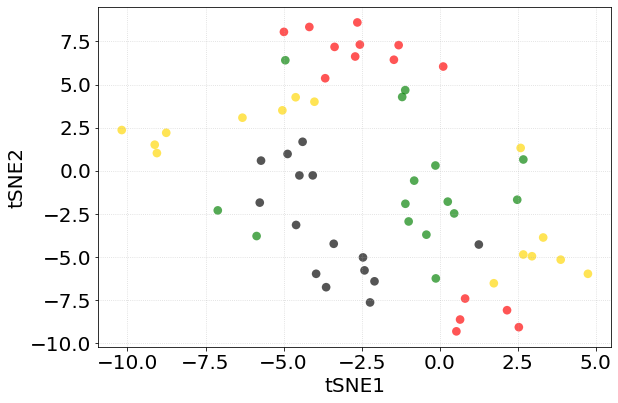

In [25]:
embedding = sklearn.manifold.TSNE(n_components=2, init='pca', verbose=1, perplexity=15, learning_rate=10, metric='cosine', early_exaggeration=20).fit_transform(x4)

matplotlib.pyplot.figure(figsize=(9, 6))

for i in range(len(sub4.index)):

  # colors
  if sub4.iloc[i]['Treatment'] == 'EGM':
    plotting_color = 'black'
  elif sub4.iloc[i]['Treatment'] == '1.0':
    plotting_color = 'green'
  elif sub4.iloc[i]['Treatment'] == '10.0':
    plotting_color = 'gold'
  elif sub4.iloc[i]['Treatment'] == '100.0':
    plotting_color = 'red'
  else:
    print('error')

  # markers
  if sub4.iloc[i]['Time'] == 0:
    plotting_marker = '*'
  elif sub4.iloc[i]['Time'] == 4:
    plotting_marker = 'o'
  elif sub4.iloc[i]['Time'] == 24:
    plotting_marker = 's'
  else:
    print('error')

  # position
  posx = embedding[i][0]
  posy = embedding[i][1]

  # plot
  matplotlib.pyplot.scatter(posx, posy, s=75, c=plotting_color, alpha=2/3, ec=None, marker=plotting_marker)

matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('tSNE1')
matplotlib.pyplot.ylabel('tSNE2')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

## UMAP for 4 h samples

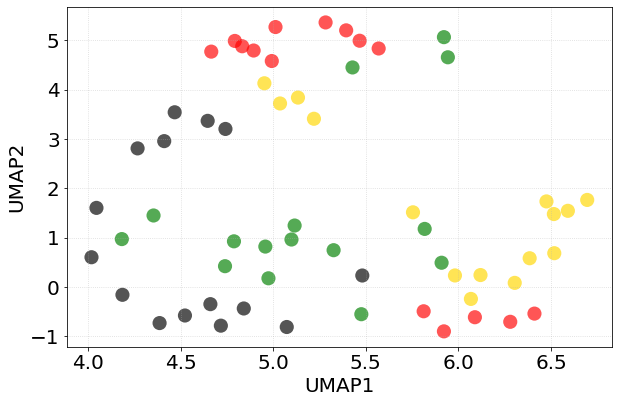

In [26]:
reducer = umap.UMAP(metric='cosine', n_neighbors=15, min_dist=0, random_state=0)
umap_embedding = reducer.fit_transform(x4)

matplotlib.pyplot.figure(figsize=(9, 6))

for i in range(len(sub4.index)):

  # colors
  if sub4.iloc[i]['Treatment'] == 'EGM':
    plotting_color = 'black'
  elif sub4.iloc[i]['Treatment'] == '1.0':
    plotting_color = 'green'
  elif sub4.iloc[i]['Treatment'] == '10.0':
    plotting_color = 'gold'
  elif sub4.iloc[i]['Treatment'] == '100.0':
    plotting_color = 'red'
  else:
    print('error')

  # markers
  if sub4.iloc[i]['Time'] == 0:
    plotting_marker = '*'
  elif sub4.iloc[i]['Time'] == 4:
    plotting_marker = 'o'
  elif sub4.iloc[i]['Time'] == 24:
    plotting_marker = 's'
  else:
    print('error')

  # position
  posx = umap_embedding[i][0]
  posy = umap_embedding[i][1]

  # plot
  matplotlib.pyplot.scatter(posx, posy, s=200, c=plotting_color, alpha=2/3, ec=None, marker=plotting_marker)

matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('UMAP1')
matplotlib.pyplot.ylabel('UMAP2')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

# Visualization for 24 h samples

## UMAP for 24 h samples

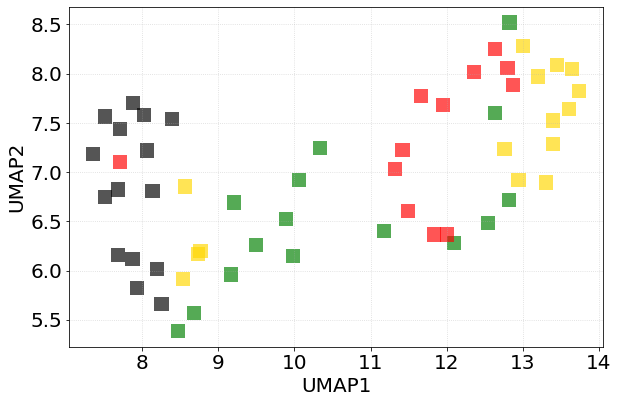

In [27]:
reducer = umap.UMAP(metric='cosine', n_neighbors=15, min_dist=0, random_state=1)
umap_embedding = reducer.fit_transform(x24)

matplotlib.pyplot.figure(figsize=(9, 6))

for i in range(len(sub24.index)):

  # colors
  if sub24.iloc[i]['Treatment'] == 'EGM':
    plotting_color = 'black'
  elif sub24.iloc[i]['Treatment'] == '1.0':
    plotting_color = 'green'
  elif sub24.iloc[i]['Treatment'] == '10.0':
    plotting_color = 'gold'
  elif sub24.iloc[i]['Treatment'] == '100.0':
    plotting_color = 'red'
  else:
    print('error')

  # markers
  if sub24.iloc[i]['Time'] == 0:
    plotting_marker = '*'
  elif sub24.iloc[i]['Time'] == 4:
    plotting_marker = 'o'
  elif sub24.iloc[i]['Time'] == 24:
    plotting_marker = 's'
  else:
    print('error')

  # position
  posx = umap_embedding[i][0]
  posy = umap_embedding[i][1]

  # plot
  matplotlib.pyplot.scatter(posx, posy, s=200, c=plotting_color, alpha=2/3, ec=None, marker=plotting_marker)

matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('UMAP1')
matplotlib.pyplot.ylabel('UMAP2')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

# Heatmap of responding features

consider
plot distributions of mutual information and F-test on scaled log2 values for 0, 0.5, 5, adn 50 uM. Make sure that there is at least log2 FC > 1.

plot the log2FC to make sure the distribution makes sense.




In [28]:
print(wdf.shape)
wdf.head()

(123, 1233)


,Treatment,Time,Replicate,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EGM,0.0,0.0,2.731190,3.039996,2.498900,3.146793,2.926058,3.101473,4.249783,...,3.021206,2.995128,3.012682,3.068779,3.026200,3.681500,3.728084,3.902864,3.798414,3.779298
1,EGM,0.0,1.0,2.577060,2.966918,2.478636,3.080018,2.975931,3.142122,4.154512,...,3.197100,3.191962,3.090010,3.086108,2.856756,3.666367,3.817882,3.767177,3.784470,3.692333
2,EGM,0.0,2.0,2.567796,3.102377,2.315301,3.174088,3.080577,3.078214,3.950247,...,3.201853,3.251763,3.087607,3.325044,2.495992,3.780564,3.908326,3.861871,3.913619,3.892816
3,EGM,0.0,3.0,2.700993,3.041685,2.328574,3.091159,2.993070,3.046918,4.165901,...,3.056800,3.136908,3.002354,3.164014,2.818191,3.743018,3.851108,3.838991,3.750062,3.818045
4,EGM,0.0,4.0,2.769198,2.967684,2.802023,3.049199,3.131748,3.324679,4.004245,...,3.029694,2.993319,2.978906,3.192828,2.418012,3.710214,3.601818,3.757961,3.739917,3.710246


## determine dose-responding features


In [29]:
delta_threshold = numpy.log10(2)
p_value_threshold = 0.05
correlations_df = pandas.DataFrame(columns=['peak name', 'log2FC', 'P value', 'r value'])

working_times = [4, 24]
#working_times = [4]
for wt in working_times:
  sub = wdf[wdf['Time'] == wt]
  print(sub.shape)

  distribution_of_fc = []
  for peak_name in peak_names:
    x = [] ; y = []
    for index, row in sub.iterrows():

      treatment = row['Treatment']
      if treatment == 'EGM':
        x.append(0)
      elif treatment == '1.0':
        x.append(1)
      elif treatment == '10.0':
        x.append(2)
      elif treatment == '100.0':
        x.append(3)
      else:
        raise ValueError('error')

      value = float(row[peak_name])
      y.append(value)
    
    # linear regression
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    ypred = slope*numpy.array(x) + intercept
    delta = numpy.abs(numpy.max(ypred) - numpy.min(ypred))
    log2FC = numpy.log2(10**delta)
    if r_value < 0:
      log2FC = -log2FC
    
    new_row = {'time':wt, 'peak name':peak_name, 'log2FC':log2FC, 'P value':p_value, 'r value':r_value}
    correlations_df = correlations_df.append(new_row, ignore_index=True)
    
    if (delta > delta_threshold) & (p_value < p_value_threshold):
      print(peak_name, delta, p_value, r_value)
  print()

correlations_df.head()

(60, 1233)
X92.925600000000003 0.39095394048784815 6.613829788621261e-05 0.4917046086428229
X133.98987 0.30805074768585694 0.000643753426015985 0.42813639123726455
X146.07991000000001 0.3172422882345902 3.9923421730868716e-05 -0.5042620087364152
X262.03859999999997 1.0787045642517983 2.240568083419162e-23 0.9064180960735609
X276.05410000000001 1.1434030356201443 1.6597029625156344e-25 0.9215605121101373
X276.05387000000002 1.0307636426885978 1.5085898777320464e-25 0.9218284440821255
X306.07519000000002 0.37000501457442825 4.059147640446921e-06 -0.555632743497677
X328.05739999999997 0.35447622683381486 0.00013578237592335747 -0.4729211478325388
X329.06038999999998 0.3142660249759617 5.16561692790371e-06 -0.5505963315417897
X360.08832000000001 0.3363583465386246 2.482280443695951e-06 -0.5656595613212589

(57, 1233)
X96.919939999999997 0.3089047149782158 0.00016546637048530223 -0.4786936329822599
X175.02331000000001 0.8658486650765549 1.050772016945141e-15 0.8321732941508259
X199.16800000

,peak name,log2FC,P value,r value,time
0,X59.01097,0.160578,0.092914,0.218881,4.0
1,X61.017890000000001,0.178149,0.050297,0.253887,4.0
2,X67.016220000000004,-0.108899,0.631602,-0.063167,4.0
3,X74.021450000000002,0.293160,0.000545,0.433248,4.0
4,X77.052040000000005,0.222653,0.006787,0.345907,4.0


In [30]:
correlations_df[correlations_df['peak name'] == 'X276.05387000000002']

,peak name,log2FC,P value,r value,time
394,X276.05387000000002,3.424123,1.508590e-25,0.921828,4.0
1624,X276.05387000000002,4.607447,5.899145e-25,0.926148,24.0


In [31]:
# add BH correction
all_p_values = correlations_df['P value'].to_list()
storage = statsmodels.stats.multitest.multipletests(all_p_values, alpha=0.1, method='fdr_bh')
corrected = storage[1]
correlations_df['corrected P value'] = corrected
correlations_df

,peak name,log2FC,P value,r value,time,corrected P value
0,X59.01097,0.160578,0.092914,0.218881,4.0,0.195190
1,X61.017890000000001,0.178149,0.050297,0.253887,4.0,0.127425
2,X67.016220000000004,-0.108899,0.631602,-0.063167,4.0,0.733935
3,X74.021450000000002,0.293160,0.000545,0.433248,4.0,0.005115
4,X77.052040000000005,0.222653,0.006787,0.345907,4.0,0.029566
...,...,...,...,...,...,...
2455,X996.78913999999997,-0.155759,0.292379,-0.141899,24.0,0.433808
2456,X996.80704000000003,-0.162769,0.233404,-0.160365,24.0,0.368296
2457,X996.82538,-0.207772,0.076811,-0.236279,24.0,0.171778
2458,X996.84303,-0.108669,0.376501,-0.119361,24.0,0.513695


In [32]:
mean = numpy.mean(correlations_df['log2FC'])
std = numpy.std(correlations_df['log2FC'])
threshold = mean + 1.959964*std
print(threshold)

dose_t = correlations_df[(numpy.abs(correlations_df['log2FC']) > threshold) & (correlations_df['corrected P value'] < 0.05)]

print(threshold)
print(dose_t.shape)
dose_t.head()

0.8314568965620487
0.8314568965620487
(63, 6)


,peak name,log2FC,P value,r value,time,corrected P value
29,X92.925600000000003,1.298721,6.613830e-05,0.491705,4.0,0.001139
31,X94.922759999999997,0.895814,9.782844e-03,0.331020,4.0,0.038382
33,X96.965789999999998,0.988130,8.079288e-03,0.338896,4.0,0.033180
37,X97.009529999999998,-0.980578,3.961084e-03,-0.366632,4.0,0.020398
41,X102.05362,-0.926010,2.800367e-07,-0.606523,4.0,0.000025


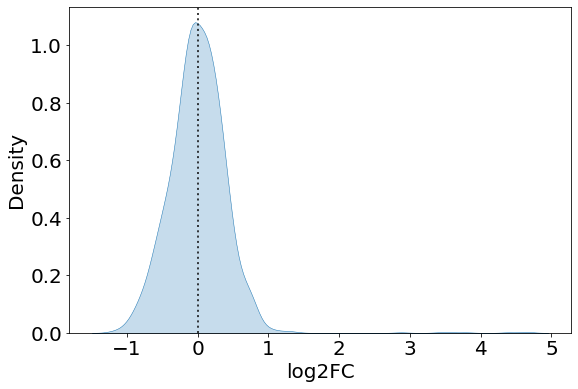

In [33]:
# histogram of log2FC
matplotlib.pyplot.figure(figsize=(9, 6))
g = seaborn.kdeplot(data=correlations_df['log2FC'], fill=True, palette="tab10", alpha=1/4, linewidth=1/2)
matplotlib.pyplot.axvline(x=0, lw=2, alpha=3/4, color='black', ls=':')
matplotlib.pyplot.show()

## generate boxplots & heatmap

In [34]:
wdf.head()

,Treatment,Time,Replicate,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EGM,0.0,0.0,2.731190,3.039996,2.498900,3.146793,2.926058,3.101473,4.249783,...,3.021206,2.995128,3.012682,3.068779,3.026200,3.681500,3.728084,3.902864,3.798414,3.779298
1,EGM,0.0,1.0,2.577060,2.966918,2.478636,3.080018,2.975931,3.142122,4.154512,...,3.197100,3.191962,3.090010,3.086108,2.856756,3.666367,3.817882,3.767177,3.784470,3.692333
2,EGM,0.0,2.0,2.567796,3.102377,2.315301,3.174088,3.080577,3.078214,3.950247,...,3.201853,3.251763,3.087607,3.325044,2.495992,3.780564,3.908326,3.861871,3.913619,3.892816
3,EGM,0.0,3.0,2.700993,3.041685,2.328574,3.091159,2.993070,3.046918,4.165901,...,3.056800,3.136908,3.002354,3.164014,2.818191,3.743018,3.851108,3.838991,3.750062,3.818045
4,EGM,0.0,4.0,2.769198,2.967684,2.802023,3.049199,3.131748,3.324679,4.004245,...,3.029694,2.993319,2.978906,3.192828,2.418012,3.710214,3.601818,3.757961,3.739917,3.710246


In [35]:
relevant_peaks = list(set(dose_t['peak name'].to_list()))
print(relevant_peaks[:5], len(relevant_peaks))

['X307.07736', 'X321.16253999999998', 'X160.05119999999999', 'X794.42385999999999', 'X146.07991000000001'] 60


In [36]:
# # generate boxplots on raw intensity
# for relevant_peak in relevant_peaks:

#   plotting_values = []
#   for condition in conditions:
#     treatment = condition[0]; timepoint = condition[1]
#     sub = wdf[(wdf['Treatment'] == treatment) & (wdf['Time'] == timepoint)][relevant_peak]
#     box = sub.values
#     plotting_values.append(box)
#     print('treatment {}, timepoint {}, shape {}'.format(treatment, timepoint, sub.shape))

#   matplotlib.pyplot.figure(figsize=(9, 6))
#   g = seaborn.boxplot(data=plotting_values)
#   h = seaborn.swarmplot(data=plotting_values, color='black', alpha=1/3)
#   g.set(ylabel='log10 norm. intensity', title='{}'.format(relevant_peak))
#   for i in range(len(g.artists)):
#     g.artists[i].set_facecolor(condition_colors[i])
#   matplotlib.pyplot.xticks(list(range(len(condition_colors))), condition_labels, fontsize=16, rotation=-45)
#   matplotlib.pyplot.tight_layout()

#   figure_path = '/content/drive/MyDrive/hi/research/huvec/results/untargeted/figures/boxplots/{}.svg'.format(relevant_peak) 
#   matplotlib.pyplot.savefig(figure_path)

In [37]:
references = [(4, 'EGM'), (24, 'EGM')]
conditions = ['1.0', '10.0', '100.0']
pdf = pandas.DataFrame()


for peak_name in relevant_peaks:
  heatmap_values = []; all_boxplot_values = []
  for reference in references:
    for condition in conditions:

      denominator_values = wdf[(wdf['Time'] == reference[0]) & (wdf['Treatment'] == reference[1])][peak_name].values
      numerator_values = wdf[(wdf['Time'] == reference[0]) & (wdf['Treatment'] == condition)][peak_name].values

      log10FC = numpy.mean(numerator_values) - numpy.mean(denominator_values)
      log2FC = numpy.log2(10**log10FC)
      heatmap_values.append(log2FC)

      boxplot_values = numpy.log2(10**(numerator_values - numpy.mean(denominator_values)))
      all_boxplot_values.append(boxplot_values)

  pdf = pandas.concat((pdf, pandas.DataFrame({peak_name:heatmap_values})), axis=1)

  # generate figure of boxplots
  g = seaborn.boxplot(data=all_boxplot_values)
  h = seaborn.swarmplot(data=all_boxplot_values, color='black', alpha=1/3)
  g.set(ylabel='log2 rel. intensity', title='{}'.format(peak_name))
  b_colors = ['tab:green', 'gold', 'tab:red', 'tab:green', 'gold', 'tab:red']
  for i in range(len(g.artists)):
    g.artists[i].set_facecolor(b_colors[i])
  matplotlib.pyplot.grid(':', alpha=0.5)
  matplotlib.pyplot.tight_layout()
  figure_path = '/home/adrian/gd15/hi/research/huvec/results/untargeted/figures/boxplots/{}.svg'.format(peak_name) 
  matplotlib.pyplot.savefig(figure_path)
  matplotlib.pyplot.clf()

print(pdf.shape)
pdf.head()

(6, 60)


,X307.07736,X321.16253999999998,X160.05119999999999,X794.42385999999999,X146.07991000000001,X321.17340000000002,X560.60392999999999,X272.79386,X438.81929000000002,X133.98987,...,X199.16800000000001,X459.32449000000003,X794.40711999999996,X885.54012999999998,X441.25072999999998,X500.92164000000002,X144.06457,X328.05739999999997,X133.98942,X115.00147
0,-0.071332,0.302865,0.248863,0.441432,-0.808564,0.273868,0.924272,0.784825,0.061581,0.327894,...,-0.217347,0.256032,0.494817,-0.493951,0.235665,-0.450986,-0.324190,-0.294119,0.177647,-0.038582
1,-0.282837,0.468293,0.260211,0.552105,-0.787716,0.545262,0.841890,0.943875,-0.073909,0.120017,...,-0.031241,-0.280032,0.469856,-0.897410,0.480701,-0.642441,-0.540060,-0.285462,0.112808,-0.021583
2,-0.896738,0.642873,0.430146,0.437386,-1.177901,0.755746,0.737056,0.743682,0.047184,1.206317,...,-0.003829,0.094621,0.336244,-0.851332,0.258212,-0.281300,-1.015238,-1.311269,1.059324,-0.528581
3,0.418606,0.303839,0.102832,-0.245329,0.230510,0.243674,-0.335639,-0.375447,-0.226050,0.318544,...,0.214431,-0.248315,-0.271384,-0.394041,0.522513,0.466293,0.039214,0.289119,0.342234,0.661208
4,0.274445,0.686765,0.567810,-0.519875,-0.088688,0.739899,-0.484846,-1.306728,-0.676191,0.229605,...,0.617077,0.669861,-0.423501,-0.278196,0.893873,0.377050,-0.143395,-0.003676,0.303839,0.414010


<Figure size 648x432 with 0 Axes>

In [38]:
# transpose df to get heatmap of features log2FC
tpdf = pdf.transpose()

In [39]:
### retention time
rtfile = '/home/adrian/gd15/hi/research/huvec/data/untargetted/annotation/AllBatches_ACID_NEG_ROSA_XCMS.xlsx'
rtinfo = pandas.read_excel(rtfile)
rtinfo.head()

,peak #NOMIS,peak #,mz,mzmin,mzmax,rt,Minutes,rtmin,rtmax,npeaks,...,EC_Rosa_1_846,EC_Rosa_1_847,EC_Rosa_1_848,EC_Rosa_1_849,EC_Rosa_1_850,EC_Rosa_1_851,EC_Rosa_1_852,isotopes,adduct,pcgroup
0,6,6,77.052052,77.050964,77.053342,73.8255,1.230425,72.814,75.227,92,...,1331.746895,1227.194092,1131.619992,1089.361258,1277.997572,955.214377,1354.787960,NaN,NaN,1
1,9,9,79.955424,79.954022,79.956540,74.3950,1.239917,72.896,74.845,15,...,112.537405,113.867823,137.576262,294.547170,135.854693,137.813230,133.426388,NaN,NaN,1
2,36,37,96.957985,96.953473,96.963500,74.3630,1.239383,72.252,77.770,75,...,375.836091,572.028820,251.999940,757.180922,226.234282,695.193460,482.003677,NaN,[M-H-C2H4]- 125.997,1
3,40,41,102.025084,102.023229,102.027498,74.0630,1.234383,73.271,75.227,34,...,310.939722,278.470358,250.039086,377.213085,363.034376,261.422147,228.808784,NaN,[M+Cl]- 67.051,1
4,57,58,110.973640,110.969712,110.977921,74.3630,1.239383,73.187,75.561,128,...,670.571843,458.353613,331.287874,1604.022880,655.803901,437.922388,580.930993,NaN,[M-H-CH2]- 125.997,1


In [40]:
# set appropriate names for features
info_file = '/home/adrian/gd15/hi/research/huvec/src/info_from_dose_responders.txt'
f = open(info_file, 'w')
print('writing info in log file...')

initial_values = tpdf.index.to_list()
target_values = annotation['dose-responding mz'].to_list()
new_index = {}

for value in initial_values:
  v = float(value[1:])
  f.write('initial \t {} \t {} \n'.format(value, v))
  annotated = annotation[numpy.abs(annotation['dose-responding mz'] - v) < 3e-4]['ottar calls'].to_list()
  #f.write('{}\n'.format(annotated))

  if annotated != []:
    c = collections.Counter(annotated).most_common()[0]
    new_index[value] = c[0]
    #f.write('most common: {} \n'.format(c[0]))
    #print(new_index[value])
    #print(type(new_index[value]))
    if type(new_index[value]) == float:
      if numpy.isnan(new_index[value]):
        new_index[value] = v
        #f.write('returning to {} because of nan \n'.format(v))
    if new_index[value] == 'unknown':
      new_index[value] = v
      #f.write('returning to {} because of unknown \n'.format(v))
    if v == 96.96579:
      #f.write('hardwired assignment to phosphate\n')
      new_index[value] = 'phosphate'
    
  else:
    message = 'Excluded bc early ret. t ' + str(v)
    new_index[value] = message
    #f.write('Not found. {} \n'.format(message))
  
  f.write('annotated as {} \n'.format(new_index[value]))
  #print(value)
  #print()

  ### retention time
  #print(v)
  retention_time = rtinfo[numpy.abs(rtinfo['mz'] - v) < 1e-4][['rt', 'mz']]
  rt = retention_time['rt'].iloc[0]
  #print(retention_time)
  #print(rt)
  #print()
  f.write('rt \t {} \n\n'.format(rt))
  # end of retention time
f.close()

annotated_df = tpdf.rename(index=new_index)

writing info in log file...


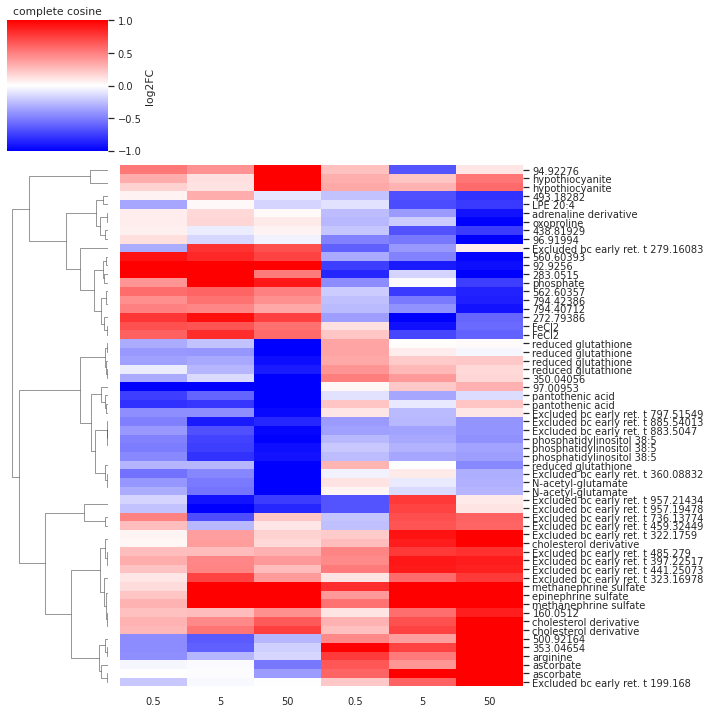

In [41]:
# generate the figure with metabolite names
linkage_method = 'complete'
distance_metric = 'cosine'

seaborn.set(font_scale=0.9)
seaborn.clustermap(annotated_df, cmap='bwr', col_cluster=False, vmin=-1, vmax=1, method=linkage_method, metric=distance_metric, yticklabels=1, xticklabels = ['0.5', '5', '50', '0.5', '5', '50'], cbar_kws={'label':'log2FC'})

matplotlib.pyplot.title('{} {}'.format(linkage_method, distance_metric))
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [42]:
annotated_df.head()

,0,1,2,3,4,5
reduced glutathione,-0.071332,-0.282837,-0.896738,0.418606,0.274445,0.155383
cholesterol derivative,0.302865,0.468293,0.642873,0.303839,0.686765,1.069829
160.0512,0.248863,0.260211,0.430146,0.102832,0.567810,0.878511
794.42386,0.441432,0.552105,0.437386,-0.245329,-0.519875,-0.877299
pantothenic acid,-0.808564,-0.787716,-1.177901,0.230510,-0.088688,0.227064


In [43]:
for element in annotated_df.index:
  print(element)

reduced glutathione
cholesterol derivative
160.0512
794.42386
pantothenic acid
cholesterol derivative
560.60393
272.79386
438.81929
hypothiocyanite
92.9256
283.0515
adrenaline derivative
493.18282
Excluded bc early ret. t 322.1759
LPE 20:4
FeCl2
N-acetyl-glutamate
pantothenic acid
94.92276
562.60357
97.00953
Excluded bc early ret. t 883.5047
cholesterol derivative
353.04654
phosphatidylinositol 38:5
Excluded bc early ret. t 279.16083
Excluded bc early ret. t 957.21434
phosphate
phosphatidylinositol 38:5
Excluded bc early ret. t 485.279
350.04056
Excluded bc early ret. t 323.16978
reduced glutathione
epinephrine sulfate
Excluded bc early ret. t 957.19478
FeCl2
methanephrine sulfate
reduced glutathione
Excluded bc early ret. t 397.22517
Excluded bc early ret. t 736.13774
Excluded bc early ret. t 360.08832
oxoproline
arginine
phosphatidylinositol 38:5
methanephrine sulfate
reduced glutathione
Excluded bc early ret. t 797.51549
96.91994
ascorbate
Excluded bc early ret. t 199.168
Excluded b

In [44]:
storing_file = '/home/adrian/gd15/hi/research/huvec/results/untargeted/heatmap_info.csv'
annotated_df.to_csv(storing_file)